# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

In [29]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [30]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [31]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [32]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [33]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [34]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           #use_unigram_document_model=False,
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [35]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [36]:
model_artm.num_document_passes=1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

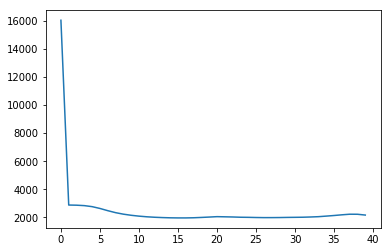

In [37]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [26]:
model_artm.topic_names

[u'sbj0',
 u'sbj1',
 u'sbj2',
 u'sbj3',
 u'sbj4',
 u'sbj5',
 u'sbj6',
 u'sbj7',
 u'sbj8',
 u'sbj9']

In [38]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    #tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:    
        print word,
    print

sbj0:  который быть что это человек этот как свой для они его весь такой время себя
sbj1:  a множитель возведение b скобка x раскладывать умножение сокращенный разложение ответ квадрат слагаемое многочлен выражение
sbj2:  обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго
sbj3:  который быть год свой время государство человек мир становиться жизнь северный первый война африка ребенок
sbj4:  x a b уравнение дробь квадратный y степень функция число f решение корень c пример
sbj5:  быть год пушкин функция свой его русский который поэт империя культура весь a f трение
sbj6:  сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина
sbj7:  который что это как человек для этот такой быть являться мочь себя она его свой
sbj8:  который быть что это свой как этот человек для x они такой государство a весь
sbj9:  который быть что этот это как человек свой для такой в

Давайте посмотрим также на разреженность матриц:

In [39]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.733318865299
0.16533613205


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [40]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary='dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [41]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [42]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  который быть что это этот как человек свой для они весь такой его время год
sbj1: 

KeyError: u'sbj1'

In [42]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.801751661594
0.285084033613


Попробуем менять коэффициент регуляризации:

In [12]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [13]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [23]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  вода корень древний квадратный океан собственный крестьянин зона достигать нет течение среди предприятие прямой луч
sbj1:  b власть свобода эпоха исторический жанр церковь бог правовой защита гражданский падение изображать философский топливо
sbj2:  слово предложение пушкин поэт стихотворение простой писатель творчество любовь роман маленький лирика глагол написать имя
sbj3:  иметь сила страна называть большой основной процесс находиться система наш высокий количество место ядро здесь
sbj4:  x a уравнение дробь звук свет формула y напряжение промежуток c ноль записывать сопротивление преломление
sbj5:  функция f империя входить ссср скорость определение область физика жидкость реформа восстание газ знак революция
sbj6:  африка сфера качество географический ресурс лермонтов ядерный среда сказка гражданин цивилизация международный поведение окружать впервые
sbj7:  герой произведение отношение социальный друг литература автор литературный поэтому личность рассказ чувство выражение 

In [15]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.904528260231
0.152100846171


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [19]:
phi = model_artm.get_phi()

In [20]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
пластинка,0.000000,0.000000,0.0,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
фотопластинка,0.000000,0.000000,0.0,0.000129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Добросклонова,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
лирикиОсобенно,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
вправе,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
лиризмуОднако,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
несостоятельность,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ПравовосознаниеПравосознание,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
поведенияОднако,0.000000,0.000126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
значинию,0.000000,0.000000,0.0,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Матрица вероятностей тем в документах.

In [22]:
theta = model_artm.get_theta()
theta

,300,301,302,303,304,305,306,307,308,309,...,190,191,192,193,194,195,196,197,198,199
sbj0,0.430423,0.488555,0.070422,0.461993,0.400157,0.332953,0.292398,0.309932,0.525158,0.184625,...,0.038217,0.227468,0.088889,0.125749,0.090395,0.106509,0.067416,0.122066,0.102190,0.035714
sbj1,0.045977,0.113402,0.023474,0.011429,0.037879,0.022599,0.087719,0.018987,0.023121,0.016406,...,0.114650,0.047210,0.040000,0.059880,0.022599,0.124260,0.061798,0.009390,0.051095,0.107143
sbj2,0.028736,0.051546,0.489427,0.005714,0.090909,0.000000,0.023392,0.443038,0.086705,0.010309,...,0.031847,0.004292,0.000000,0.023952,0.011299,0.000000,0.022472,0.000000,0.058394,0.000000
sbj3,0.109195,0.030928,0.258216,0.297143,0.151515,0.338983,0.181287,0.101266,0.070218,0.427835,...,0.286624,0.274678,0.160000,0.125748,0.129944,0.124260,0.089888,0.173709,0.131387,0.125000
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.029347,0.051546,0.004695,0.028616,0.022727,0.028249,0.064327,0.019182,0.057803,0.061856,...,0.012739,0.038627,0.031111,0.023952,0.118644,0.030391,0.151685,0.028169,0.000423,0.000000
sbj6,0.068966,0.021755,0.009390,0.017963,0.024086,0.016949,0.076023,0.044304,0.028902,0.077320,...,0.210191,0.167382,0.462222,0.377246,0.231638,0.348307,0.264045,0.370892,0.393737,0.000000
sbj7,0.022989,0.067010,0.023474,0.011429,0.166667,0.011680,0.070175,0.018987,0.138728,0.025773,...,0.203822,0.012876,0.062222,0.035928,0.039548,0.059172,0.044944,0.014085,0.197080,0.428571
sbj8,0.252873,0.175258,0.088038,0.148571,0.098485,0.101695,0.198830,0.044304,0.057803,0.170103,...,0.095541,0.166619,0.137778,0.227545,0.338983,0.207101,0.297753,0.140845,0.065693,0.125000
sbj9,0.011494,0.000000,0.032864,0.017143,0.007576,0.146893,0.005848,0.000000,0.011561,0.025773,...,0.006369,0.060848,0.017778,0.000000,0.016949,0.000000,0.000000,0.140845,0.000000,0.178571


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [28]:
theta_test = model_artm.transform(batch_vectorizer)